# Tutorial: Pitch & Frequency Analysis with librosa

This tutorial explores how to analyze pitch and frequency content in audio. Understanding harmonic content is fundamental to computational musicology, automatic transcription, and instrument recognition.

**What you'll learn:**
- How to visualize frequency spectra
- How to create chromagrams for harmonic analysis
- How to detect pitch using the PYIN algorithm
- How to separate harmonic and percussive components

## Step 1: Setup

Install and import the required libraries.

In [ ]:
# Install libraries
!pip install librosa soundfile

# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from collections import Counter

print("Libraries loaded successfully!")

## Step 2: Load Audio and View Spectrum

The frequency spectrum shows the intensity of each frequency at a single moment—like a snapshot of harmonic content.

In [ ]:
# Load audio
y, sr = librosa.load(librosa.ex('trumpet'))

# Listen to the audio
print("Listen to the audio:")
Audio(y, rate=sr)

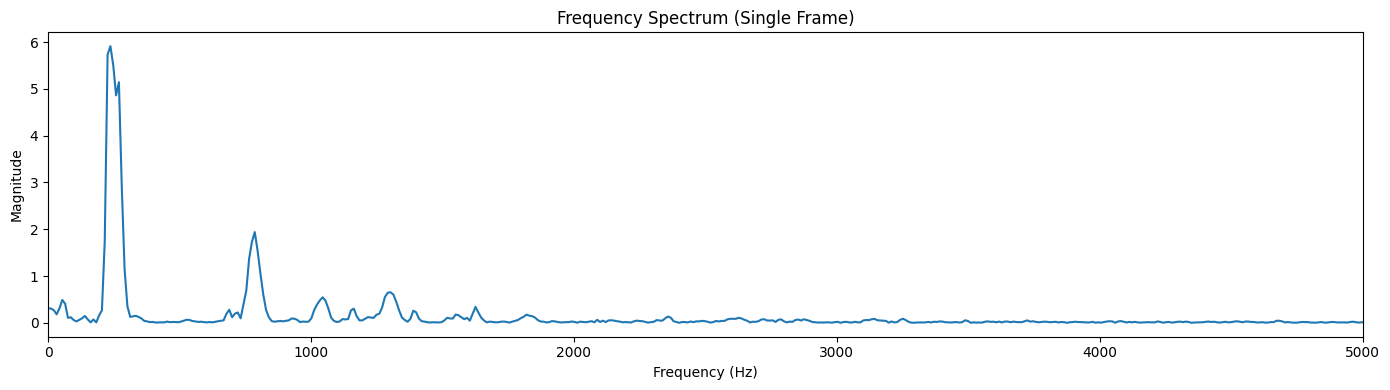

In [1]:
# Compute the Short-Time Fourier Transform
D = librosa.stft(y)

# Take the magnitude of one frame (middle of the audio)
frame_idx = len(D[0]) // 2
spectrum = np.abs(D[:, frame_idx])

# Create frequency axis
frequencies = librosa.fft_frequencies(sr=sr)

# Plot the spectrum
plt.figure(figsize=(14, 4))
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum (Single Frame)')
plt.xlim(0, 5000)  # Focus on 0-5000 Hz
plt.tight_layout()
plt.show()

**Reading a spectrum:**
- First peak (leftmost) = Fundamental frequency
- Higher peaks = Harmonics (integer multiples of fundamental)
- Pattern of peak heights = Instrument timbre

## Step 3: Create a Chromagram

A **chromagram** shows energy in each of the 12 pitch classes (C, C#, D, etc.) over time. It collapses all octaves together—useful for chord detection and key analysis.

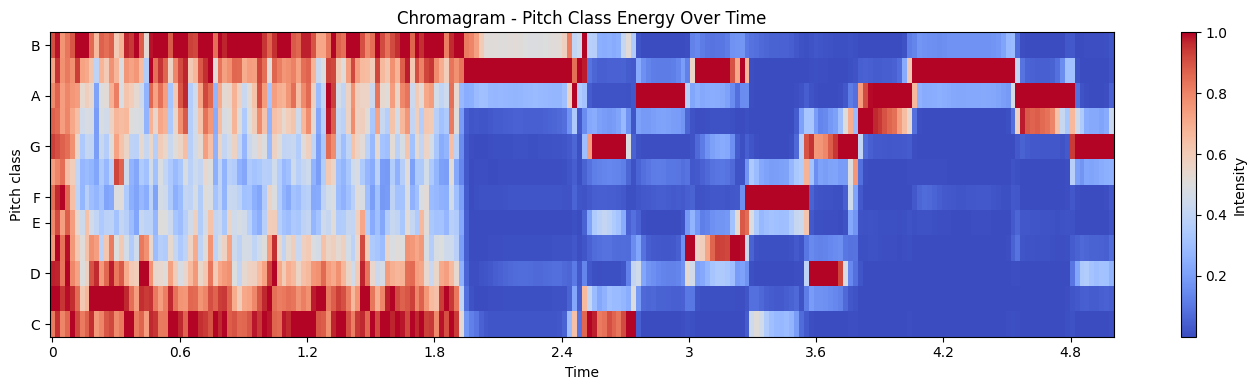

In [1]:
# Compute the chromagram
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Plot
plt.figure(figsize=(14, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
plt.colorbar(label='Intensity')
plt.title('Chromagram - Pitch Class Energy Over Time')
plt.tight_layout()
plt.show()

**Reading a chromagram:**
- Bright horizontal bands = Strong pitch class presence
- Vertical patterns = Chord changes
- Constant brightness in one row = Sustained note or pedal tone

## Step 4: Pitch Detection with PYIN

**PYIN** (Probabilistic YIN) detects the fundamental frequency of a monophonic signal—perfect for melody analysis.

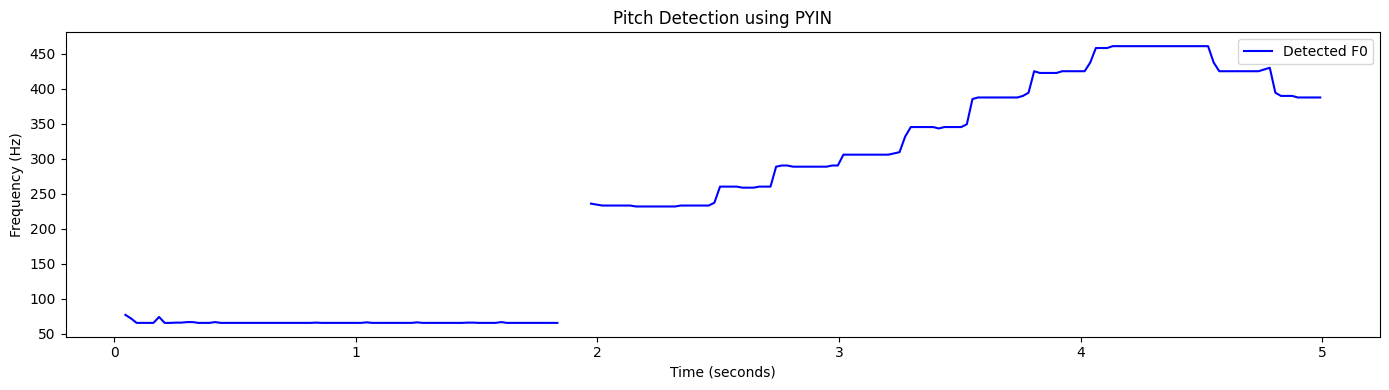

In [1]:
# Detect pitch using PYIN
f0, voiced_flag, voiced_probs = librosa.pyin(
    y, 
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7')
)

# Create time axis
times = librosa.times_like(f0)

# Plot the detected pitch
plt.figure(figsize=(14, 4))
plt.plot(times, f0, label='Detected F0', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Detection using PYIN')
plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
valid_f0 = f0[~np.isnan(f0)]
if len(valid_f0) > 0:
    print(f"Average detected pitch: {np.mean(valid_f0):.1f} Hz")
    print(f"Pitch range: {np.min(valid_f0):.1f} - {np.max(valid_f0):.1f} Hz")

## Step 5: Convert Frequencies to Note Names

Make pitch analysis more musical by converting frequencies to note names.

In [ ]:
# Convert detected pitches to note names
def hz_to_note_name(freq):
    """Convert frequency to note name, handling NaN values."""
    if np.isnan(freq):
        return None
    return librosa.hz_to_note(freq)

# Get unique notes detected
valid_pitches = f0[~np.isnan(f0)]
note_names = [hz_to_note_name(freq) for freq in valid_pitches]

# Count occurrences of each note
note_counts = Counter(note_names)

print("Most common notes detected:")
for note, count in note_counts.most_common(10):
    print(f"  {note}: {count} frames")

## Step 6: Overlay Pitch on Spectrogram

Visualizing detected pitch on a spectrogram helps verify accuracy—the pitch line should follow the brightest harmonic contours.

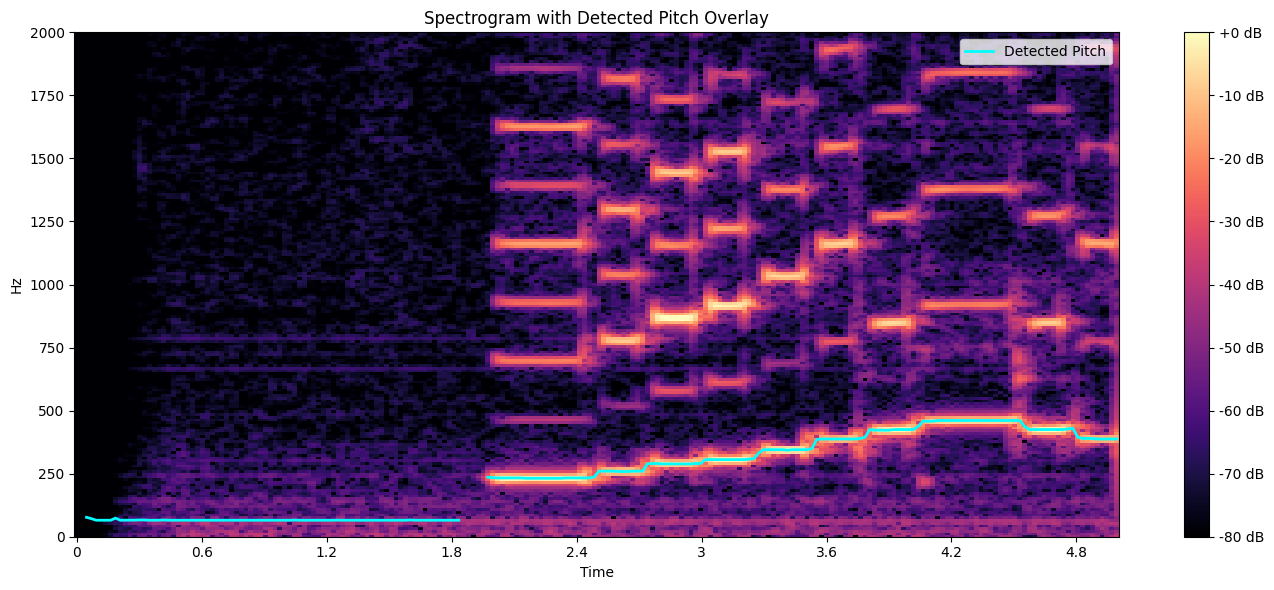

In [1]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot spectrogram
D_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='hz', ax=ax, cmap='magma')

# Overlay detected pitch
times = librosa.times_like(f0)
ax.plot(times, f0, color='cyan', linewidth=2, label='Detected Pitch')

ax.set_ylim(0, 2000)  # Focus on lower frequencies
ax.legend(loc='upper right')
ax.set_title('Spectrogram with Detected Pitch Overlay')
plt.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Step 7: Harmonic-Percussive Source Separation

librosa can separate **harmonic** (pitched) and **percussive** (rhythmic) components. This is useful for isolating melody or drums.

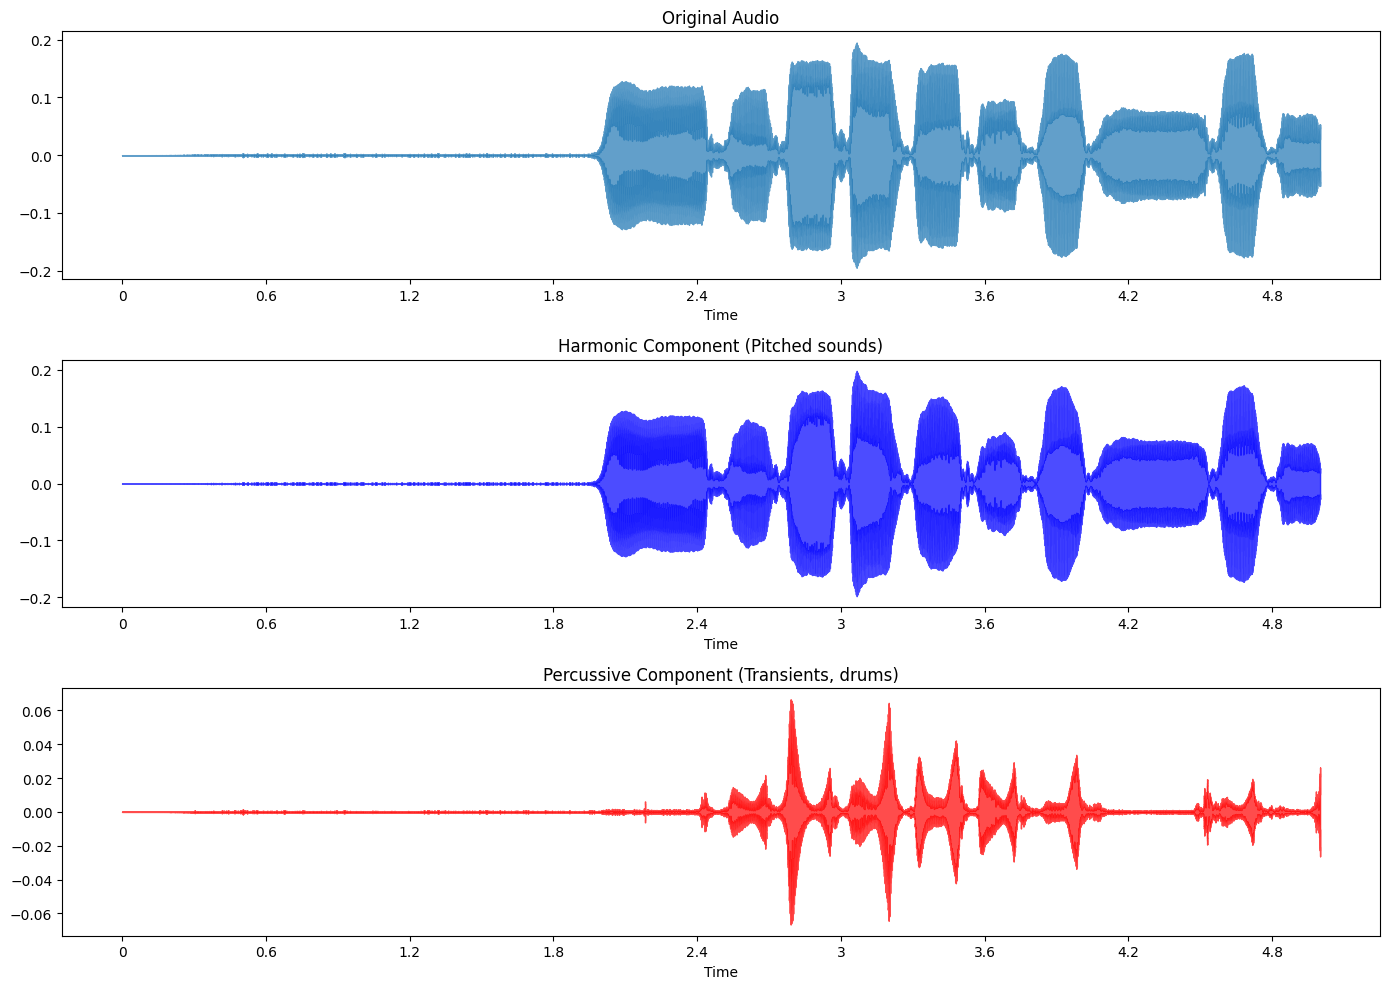

In [1]:
# Separate harmonic and percussive components
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original
librosa.display.waveshow(y, sr=sr, ax=axes[0], alpha=0.7)
axes[0].set_title('Original Audio')

# Harmonic
librosa.display.waveshow(y_harmonic, sr=sr, ax=axes[1], alpha=0.7, color='blue')
axes[1].set_title('Harmonic Component (Pitched sounds)')

# Percussive
librosa.display.waveshow(y_percussive, sr=sr, ax=axes[2], alpha=0.7, color='red')
axes[2].set_title('Percussive Component (Transients, drums)')

plt.tight_layout()
plt.show()

In [ ]:
# Listen to the original
print("Original:")
Audio(y, rate=sr)

In [ ]:
# Listen to harmonic component
print("Harmonic component only (pitched sounds):")
Audio(y_harmonic, rate=sr)

In [ ]:
# Listen to percussive component
print("Percussive component only (transients):")
Audio(y_percussive, rate=sr)

## Step 8: Key Detection via Pitch Class Distribution

Analyzing which pitch classes are most prominent can hint at the musical key.

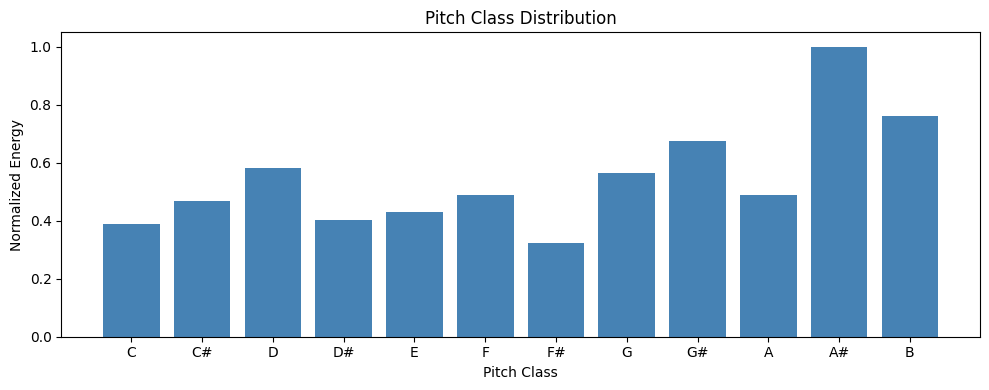

In [1]:
# Compute chromagram (using CQT for better low-frequency resolution)
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

# Sum across time to get overall pitch class distribution
chroma_sum = np.sum(chroma, axis=1)

# Normalize
chroma_sum = chroma_sum / np.max(chroma_sum)

# Pitch class names
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Plot pitch class distribution
plt.figure(figsize=(10, 4))
plt.bar(pitch_classes, chroma_sum, color='steelblue')
plt.xlabel('Pitch Class')
plt.ylabel('Normalized Energy')
plt.title('Pitch Class Distribution')
plt.tight_layout()
plt.show()

# Find the most prominent pitch class
dominant_pc = pitch_classes[np.argmax(chroma_sum)]
print(f"Most prominent pitch class: {dominant_pc}")
print("(This suggests the piece may be in or related to this key)")

## Step 9: Complete Pitch Analysis Function

A reusable function for comprehensive pitch analysis.

In [ ]:
def analyze_pitch(y, sr):
    """Comprehensive pitch analysis function."""
    
    results = {}
    
    # 1. Detect pitch with PYIN
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y, 
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7')
    )
    
    valid_f0 = f0[~np.isnan(f0)]
    
    if len(valid_f0) > 0:
        results['avg_pitch_hz'] = float(np.mean(valid_f0))
        results['min_pitch_hz'] = float(np.min(valid_f0))
        results['max_pitch_hz'] = float(np.max(valid_f0))
        results['avg_note'] = librosa.hz_to_note(results['avg_pitch_hz'])
    else:
        results['avg_pitch_hz'] = None
        results['avg_note'] = None
    
    # 2. Compute chromagram and find dominant pitch class
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_sum = np.sum(chroma, axis=1)
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    results['dominant_pitch_class'] = pitch_classes[np.argmax(chroma_sum)]
    
    # 3. Harmonic-Percussive ratio
    y_harm, y_perc = librosa.effects.hpss(y)
    harm_energy = np.sum(y_harm**2)
    perc_energy = np.sum(y_perc**2)
    results['harmonic_ratio'] = float(harm_energy / (harm_energy + perc_energy + 1e-10))
    
    return results

# Run analysis
results = analyze_pitch(y, sr)

print("=== Pitch Analysis Results ===")
for key, value in results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

## Step 10: Upload Your Own Audio

Try the analysis on your own audio file!

In [ ]:
# Upload your own file
from google.colab import files

uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    y_custom, sr_custom = librosa.load(filename)
    
    print(f"\nLoaded: {filename}")
    print(f"Duration: {len(y_custom) / sr_custom:.2f} seconds")
    
    # Analyze
    results_custom = analyze_pitch(y_custom, sr_custom)
    
    print("\n=== Analysis Results ===")
    for key, value in results_custom.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
    
    # Listen
    Audio(y_custom, rate=sr_custom)

## Practice Exercises

1. **Compare instruments**: Load trumpet, piano, and guitar recordings and compare their harmonic ratios
2. **Melody extraction**: Use HPSS to isolate harmonic content, then run PYIN on that
3. **Transpose detection**: Compare chromagrams of two versions of the same song in different keys

In [ ]:
# Practice space - try the exercises here!

# Exercise 2: Improved pitch detection on harmonic-only audio
# y_harm, _ = librosa.effects.hpss(y)
# f0_harm, _, _ = librosa.pyin(y_harm, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
# # Compare with original f0...

## Key Concepts Summary

1. **Frequency spectrum** shows harmonic content at one moment
2. **Chromagrams** show pitch class energy over time (octave-independent)
3. **PYIN** detects fundamental frequency in monophonic audio
4. **Harmonic-Percussive separation** isolates pitched and rhythmic elements
5. **Pitch class distribution** can hint at musical key

---

**Next tutorial**: Learn about audio effects and exporting with soundfile!